In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(8,3.5))

<Figure size 800x350 with 0 Axes>

In [2]:
df1 = pd.read_csv('2018年氮肥施用量(农田汇总).csv')
df1 = df1.fillna(0)

In [3]:
df2 = pd.read_csv('2018年氮肥施用量(汇总).csv')
df2 = df2.fillna(0)

In [4]:
file_path = '/Users/xihuan/Desktop/土壤信息数据集/4.数据整理/prediction/EF_prediction/'
file_names = sorted([file for file in os.listdir(file_path) if file.endswith('.csv')], key=lambda x: len(x))
file_names

['EF_predicted(clear_datas3).csv',
 'EF_predicted(clear_datas234).csv',
 'EF_predicted(clear_datas124).csv',
 'EF_predicted(clear_datas123).csv',
 'EF_predicted(clear_datas134).csv',
 'EF_predicted(clear_datas1234).csv',
 'EF_predicted(clear_datas3(9.2)).csv',
 'EF_predicted(Supplementary(6.6晚)).csv',
 'EF_predicted(Supplementary(6.8晚)).csv',
 'EF_predicted(Supplementary(6.2晚)).csv']

In [5]:
dataset_names = []
nh3_prediction = []
nh3_std = []
all_data = dict()

for filename in file_names:

    df_ef =  pd.read_csv(file_path+filename)
    df_ef = df_ef.merge(pd.DataFrame({'grid_num':range(1, 360*720+1)}), on='grid_num', how='right')
    df_ef = df_ef.fillna(0)

    #水稻、玉米和小麦三种作物各种两季，需将网格对应的EF值乘以6来算一年的NH3排放量
    # print(f'NH3农田排放({'EF_predicted(clear_datas1234).csv'.rsplit('.',1)[0].rsplit('(',1)[1].rsplit(')',1)[0]})：{6 * sum(df1['fertilizer_input'].values * df_ef['EF_predicted'].values)/100*1e-12} Tg N/yr')
    title = f'NH3排放({filename.rsplit(".",1)[0].split("(",1)[1].rsplit(")",1)[0]})'
    value = format(6 * sum(df2['fertilizer_input'].values * df_ef['EF_predicted'].values)/100, '.2e')

    title_std = f'样本标准差({filename.rsplit(".",1)[0].split("(",1)[1].rsplit(")",1)[0]})'
    sample_std = format(6 * np.std(df2['fertilizer_input'].values * df_ef['EF_predicted'].values, ddof=1)*np.sqrt(len(df2['fertilizer_input'].values))/100, '.2e')

    dataset_names.append(filename.rsplit(".",1)[0].split("(",1)[1].rsplit(")",1)[0])
    nh3_prediction.append(value)
    nh3_std.append(sample_std)
    all_data[f'{filename.rsplit(".",1)[0].split("(",1)[1].rsplit(")",1)[0]}'] = df_ef['EF_predicted'].values

result = pd.DataFrame({'Dataset': dataset_names, 'NH3 emission prediction（g）': nh3_prediction, 'Samples std（g）': nh3_std})
print(result)

               Dataset NH3 emission prediction（g） Samples std（g）
0         clear_datas3                   3.35e+12       2.68e+10
1       clear_datas234                   3.00e+12       2.46e+10
2       clear_datas124                   4.01e+12       3.12e+10
3       clear_datas123                   3.06e+12       2.50e+10
4       clear_datas134                   3.13e+12       2.54e+10
5      clear_datas1234                   2.91e+12       2.38e+10
6    clear_datas3(9.2)                   3.20e+12       2.59e+10
7  Supplementary(6.6晚)                   3.80e+12       2.97e+10
8  Supplementary(6.8晚)                   3.89e+12       3.05e+10
9  Supplementary(6.2晚)                   4.00e+12       3.13e+10


In [7]:
result.to_excel('./EF_prediction/NH3 emission prediction.xlsx', index=False)

In [8]:
new_names = ['D7', 'D1', 'D3', 'D4', 'D2', 'D0', 'D8', 'D5', 'D9', 'D6']
dict_names = dict(zip(new_names, dataset_names))
mapped_labels = [dict_names[label] for label in new_names]

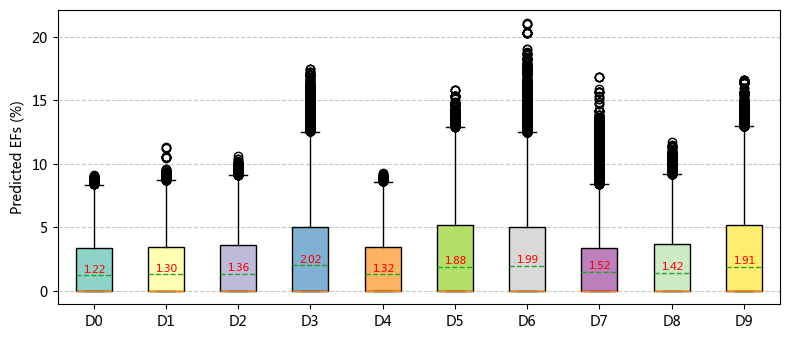

In [9]:
# 定义特定的键顺序列表
specific_order = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
# 按照特定顺序构造新的字典
ordered_all_data = {key: all_data[dict_names[key]] for key in specific_order}

# 抽取排序后的列表值
data_series = []
labels = []
for key, value in ordered_all_data.items():
    data_series.append(value)  # 收集每个键对应的序列
    labels.append(key)

# 绘制箱线图
box = plt.boxplot(data_series, patch_artist=True, labels=labels, showmeans=True, meanline=True)

# 美化箱线图
colors = plt.cm.Set3(np.linspace(0, 1, len(mapped_labels)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# 计算每个数据集的平均值并标注
for i, data in enumerate(data_series):
    mean_val = np.mean(data)
    # 在箱线图上方标注平均值，位置可根据实际情况调整
    plt.text(i + 1, mean_val + 0.2, f'{mean_val:.2f}', ha='center', color='red', fontsize=8)

# 添加标题和标签
# plt.xlabel("循环次数")
plt.ylabel("Predicted EFs (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()

# 可选：保存图形
plt.savefig('EF_boxplot.svg')

# 显示图形
plt.show()